In [7]:
from denoisers.NLM import *
from PIL import *
from iterative_algorithms import *
from forward_models import *
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import scipy.ndimage

import pandas as pd
from deepinv_denoiser import *
from scipy.ndimage import zoom


plt.rcParams['figure.figsize'] = (2,2)  # Width, Height in inches

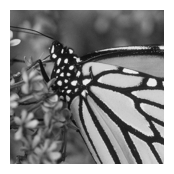

In [8]:
#read the image
image = Image.open("./images/5.png")
#convert the image to a numpy array
image = np.array(image)
#to double
image = image.astype(np.float64)
#to range 0 to 1P_operator
image = image/255.0


#plot image using plotly
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

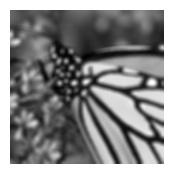

Initiated ...


In [9]:
# ------ BLURRING ----------#
A_function = gaussian_blurring
A_kwargs = {'radius':4,'sigma': 4}
A_function_adjoint = gaussian_blurring
A_adjoint_kwargs = A_kwargs
#-------- END BLURRING -------#



b0 = A_function(image, **A_kwargs) 


plt.imshow(b0, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()


print("Initiated ...")

In [10]:
def PnP_ISTA(input_image,start_image,denoiser,denoiser_args,step_size=0.9,num_iterations=10):
    x_old = start_image.copy()
    y = start_image.copy()

    N = []
    psnrs = [psnr(x_old, image, data_range=1.0)]

    for i in range(num_iterations):
        #calculate G(y)
        y = y - step_size*A_function_adjoint(A_function(y,**A_kwargs),**A_adjoint_kwargs) + step_size*A_function_adjoint(input_image,**A_adjoint_kwargs)
        y = y.astype(np.float32)
        #calculate x
        x = denoiser(y,**denoiser_args) 
        y = x 
        
        
        psnr_value = psnr(x, image, data_range=1.0)

        error_norm = np.linalg.norm(x-x_old,'fro')
   
        N.append(error_norm)

        psnrs.append(psnr_value)

        if i%1000 == 0 and i>1:
            #plot the image
            plt.imshow(x, cmap='gray')
            plt.axis('off')
            plt.show()
            plt.close()



            fig, axs = plt.subplots(1, 2, figsize=(4, 2))

            # Plot N
            axs[0].plot(N)
            axs[0].set_title(r'$\|x_{k+1} - x_k\|_2$')
            axs[0].set_xscale('symlog')
            axs[0].set_yscale('log')

            # Plot psnrs
            axs[1].plot(psnrs)
            axs[1].set_title('PSNRs')
            axs[1].set_xscale('symlog')
            # axs[1].set_yscale('log')


            plt.show()
            plt.close()
        
        if i%1000 == 0:
            print("Iteration:",i)
            print("PSNR:", psnr_value)
            # print("Lips:", lips[-1])
            print("Norm:", error_norm)
            print("-------------------------------")
      
        x_old = x
       
    return x,N



In [11]:
####set parameters
den_name = "drunet"
# denoiser_deep = denoiser_dncnn
denoiser_deep = denoiser_drunet
sig = 5.0
# stp = 0.361
stp = 0.9

Iteration: 0
PSNR: 21.15912898019204
Norm: 4.170067080310721
-------------------------------


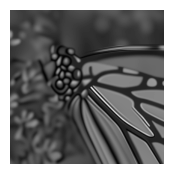

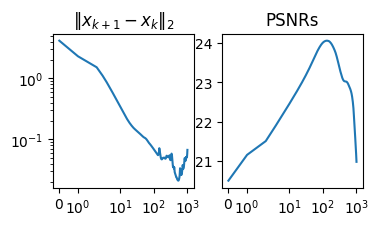

Iteration: 1000
PSNR: 20.981801157509214
Norm: 0.067429796
-------------------------------


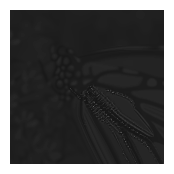

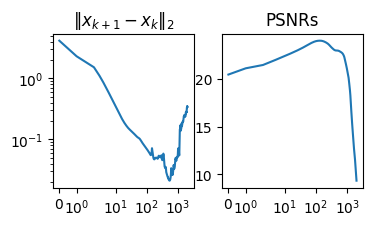

Iteration: 2000
PSNR: 9.347591718783336
Norm: 0.34349692
-------------------------------


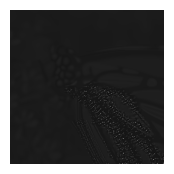

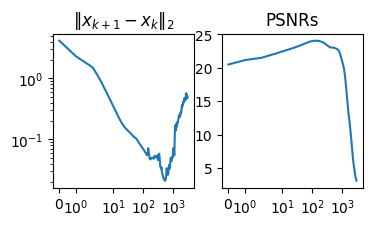

Iteration: 3000
PSNR: 3.1231496407222723
Norm: 0.4885223
-------------------------------


In [12]:
_,_ = PnP_ISTA(b0,b0,run_deepinv,{'sigma':sig/255.0,'denoiser_deep':denoiser_deep}
                                          ,step_size=stp,num_iterations=3001)